In [1]:
pwd

'/mmfs1/data/aglinska/Contrastive-Machine-Learning-reveals-the-structure-of-individual-variation-in-ASD/Notebooks'

In [2]:
import numpy as np 
import pandas as pd
import ants

from tqdm import tqdm
from umap import UMAP
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.stats import kendalltau

In [3]:
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

In [4]:
subs = df_asd['BIDS_ID'].values

In [5]:
fn_temp = '../../jacobians/normed_Js_masked/{}_normed_Js_masked.nii'

In [6]:
ims = [ants.image_read(fn_temp.format(sub)) for sub in tqdm(subs)]

100%|██████████| 470/470 [00:03<00:00, 124.43it/s]


In [7]:
flatmap = np.array([im.numpy().flatten() for im in ims]) 
evox = ((flatmap**2).sum(axis=0)!=0)
flatmap = flatmap[:,evox] # only analyze voxels with values > 0
flatmap = flatmap-flatmap.mean(axis=0) # center each voxel at zero
flatmap.shape

(470, 55432)

In [8]:
mean_J = ims[0].new_image_like(np.array([im.numpy() for im in ims]).mean(axis=0))

In [9]:
# LOSO PCA
est_pca = False # Takes a while to run each time, estimate or load precomputed?
if est_pca:
    ns = flatmap.shape[0]
    j_pca_loso = np.array([PCA().fit(flatmap[np.arange(ns)!=s]).transform(flatmap[s,:][np.newaxis,:]) for s in tqdm(range(ns))])
    np.save(file='../Data/j_pca_loso.npy',arr=j_pca_loso)
else:
    j_pca_loso = np.load('../Data/j_pca_loso.npy')

j_pca_loso_2 = j_pca_loso[:,0,0:2]

In [10]:
j_pca = j_pca_loso_2 # which PCA to use

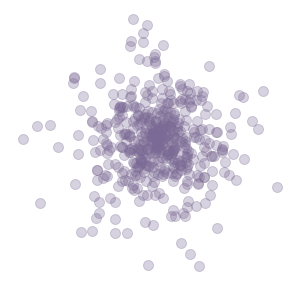

In [11]:
#fig = plt.figure(figsize=(5,5))
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(j_pca[:,0],j_pca[:,1],alpha=.3,s=100,color=np.array([123,106,149])/255)
plt.xticks([])
plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color("white")
    #ax.spines[axis].set_zorder(0)
    
plt.savefig('PCA_scatterplot.pdf')

In [12]:
corr = kendalltau

In [13]:
jacobians_flat = np.array([im.numpy().flatten() for im in ims])

In [14]:
jacobians_flat.shape

(470, 262144)

In [15]:
# DO X AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,0]) for v in tqdm(range(jacobians_flat.shape[1]))])
xcorr_r = res[:,0]
xcorr_p = res[:,1]

100%|██████████| 262144/262144 [01:07<00:00, 3896.85it/s]


In [16]:
# DO Y AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,1]) for v in tqdm(range(jacobians_flat.shape[1]))])
ycorr_r = res[:,0]
ycorr_p = res[:,1]

100%|██████████| 262144/262144 [01:06<00:00, 3934.08it/s]


In [17]:
# BONF CORRECT MAPS
xcorr_r_threshed = xcorr_r.copy()
ycorr_r_threshed = ycorr_r.copy()

p_thresh = .05/(~np.isnan(xcorr_p)).sum()
print(p_thresh)

xcorr_r_threshed[xcorr_p>p_thresh]=np.nan
ycorr_r_threshed[ycorr_p>p_thresh]=np.nan

9.020060614807332e-07


In [18]:
(~np.isnan(xcorr_p)).sum()

55432

In [19]:
print((abs(xcorr_r_threshed[xcorr_p<p_thresh])).min()) # minimum x value to be significant
print((abs(ycorr_r_threshed[ycorr_p<p_thresh])).min()) # minimum y value to be significant

0.15162183005942928
0.15161344469350177


In [20]:
# Show tau value ranges (neg and pos)
print((xcorr_r_threshed[xcorr_r_threshed<0].min().round(2),xcorr_r_threshed[xcorr_r_threshed<0].max().round(2)))
print((xcorr_r_threshed[xcorr_r_threshed>0].min().round(2),xcorr_r_threshed[xcorr_r_threshed>0].max().round(2)))

print((ycorr_r_threshed[ycorr_r_threshed<0].min().round(2),ycorr_r_threshed[ycorr_r_threshed<0].max().round(2)))
print((ycorr_r_threshed[ycorr_r_threshed>0].min().round(2),ycorr_r_threshed[ycorr_r_threshed>0].max().round(2)))

(-0.52, -0.15)
(0.15, 0.58)
(-0.45, -0.15)
(0.15, 0.58)


In [24]:
temp = ants.image_read('../Data/Atlas_brain_2mm.nii')
temp = temp.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [25]:
# Make nii
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')

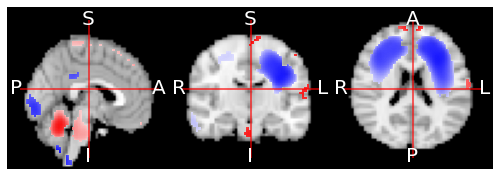

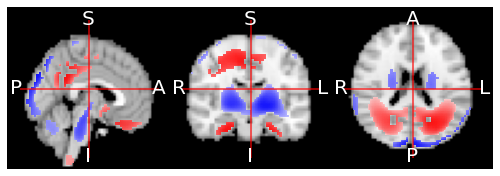

In [26]:
temp.plot_ortho(xcorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')
temp.plot_ortho(ycorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')

In [27]:
ycorr_r_threshed[np.isnan(ycorr_r_threshed)]=0
xcorr_r_threshed[np.isnan(xcorr_r_threshed)]=0

In [28]:
print(np.nanmin(xcorr_r).round(3),np.nanmean(xcorr_r).round(3),np.nanmax(xcorr_r).round(3))
print(np.nanmin(ycorr_r).round(3),np.nanmean(ycorr_r).round(3),np.nanmax(ycorr_r).round(3))

-0.521 -0.045 0.585
-0.453 0.005 0.577


## CORRELATE PCA W/ SYMPTOMS

In [29]:
# CORR PCA W/ SYMOTOMS
keys = ['ADOS_Comm','ADOS_Social','ADOS_StBeh','AgeAtScan','Sex','FIQ']
npcs = 2 # How many PCs
# Make dataframe
col1 = list()
col2 = list()
for key in keys:
    for i in ['r','p','df']:
        col1.append(key)
        col2.append(i)
#columns = [[key,key],['r','p']]
columns = [col1,col2]
res_corr = pd.DataFrame(np.zeros((npcs,len(col1))),columns=columns)

for key in keys:
    for pc in range(npcs):
        vec_behav = df[key].values[patients]
        #vec_pca = j_pca_loso[:,0,pc]
        vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)
        r,p = corr(vec_behav[~e],vec_pca[~e])
        res_corr.loc[pc].at[(key,'r')] = r
        res_corr.loc[pc].at[(key,'p')] = p
        res_corr.loc[pc].at[(key,'df')] = len(vec_behav[~e])-2

In [30]:
pd.options.display.max_columns = None
res_corr

ADOS_Comm                  ADOS_Social                  ADOS_StBeh  \
          r         p     df           r         p     df          r   
0  0.092896  0.017455  342.0    0.056288  0.136015  343.0   0.098143   
1  0.080827  0.038626  342.0   -0.042589  0.259333  343.0  -0.061405   

                   AgeAtScan                        Sex                   \
          p     df         r         p     df         r         p     df   
0  0.023156  283.0  0.057140  0.064370  468.0  0.037782  0.316805  468.0   
1  0.155377  283.0  0.043463  0.159456  468.0  0.007237  0.847932  468.0   

        FIQ                   
          r         p     df  
0  0.004525  0.889681  426.0  
1  0.016245  0.618488  426.0

In [31]:
# make sure Kendall taus are used 
corr

<function scipy.stats.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto')>

In [34]:
these_keys = ['ADOS_Comm','ADOS_Social','ADOS_StBeh','AgeAtScan','Sex','FIQ']
for pc in range(res_corr.shape[0]):
    for key in these_keys:
        p = res_corr[key]['p'][pc]
        r = res_corr[key]['r'][pc]
        dgf = res_corr[key]['df'][pc]
        
        if p < .05:
            print(f'PC{pc} | {key} | $\\tau$({int(dgf)}) = {r:.2f}, p = {p:.3f}')

PC0 | ADOS_Comm | $\tau$(342) = 0.09, p = 0.017
PC0 | ADOS_StBeh | $\tau$(283) = 0.10, p = 0.023
PC1 | ADOS_Comm | $\tau$(342) = 0.08, p = 0.039


### split into positive and negative

In [35]:
c1 = ants.image_read('../Data/c1Atlas_brain_2mm.nii').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)
c2 = ants.image_read('../Data/c2Atlas_brain_2mm.nii').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [36]:
xcorr_r_nii = ims[0].new_image_like(xcorr_r.reshape((64,64,64)))# .to_filename('xcorr.nii')
ycorr_r_nii = ims[0].new_image_like(ycorr_r.reshape((64,64,64)))# .to_filename('ycorr.nii')

xcorr_r_threshed_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64)))# .to_filename('xcorr-bonf.nii')
ycorr_r_threshed_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64)))# .to_filename('ycorr-bonf.nii')

In [37]:
xcorr_r_nii_nii_pos = xcorr_r_nii.copy()
xcorr_r_nii_nii_neg = xcorr_r_nii.copy()
xcorr_r_nii_nii_pos[xcorr_r_nii<0] = 0
xcorr_r_nii_nii_neg[xcorr_r_nii>0] = 0

ycorr_r_nii_nii_pos = ycorr_r_nii.copy()
ycorr_r_nii_nii_neg = ycorr_r_nii.copy()
ycorr_r_nii_nii_pos[ycorr_r_nii<0] = 0
ycorr_r_nii_nii_neg[ycorr_r_nii>0] = 0

xcorr_r_nii_nii_neg = xcorr_r_nii_nii_neg.new_image_like(abs(xcorr_r_nii_nii_neg.numpy()))
ycorr_r_nii_nii_neg = ycorr_r_nii_nii_neg.new_image_like(abs(ycorr_r_nii_nii_neg.numpy()))

xcorr_r_nii_nii_pos[np.isnan(xcorr_r_nii_nii_pos.numpy())] = 0
xcorr_r_nii_nii_neg[np.isnan(xcorr_r_nii_nii_neg.numpy())] = 0
ycorr_r_nii_nii_pos[np.isnan(ycorr_r_nii_nii_pos.numpy())] = 0
ycorr_r_nii_nii_neg[np.isnan(ycorr_r_nii_nii_neg.numpy())] = 0

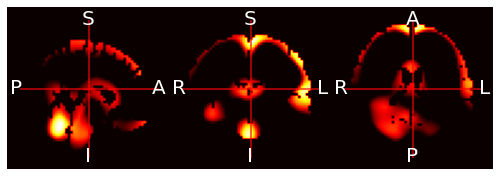

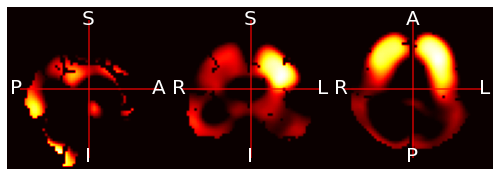

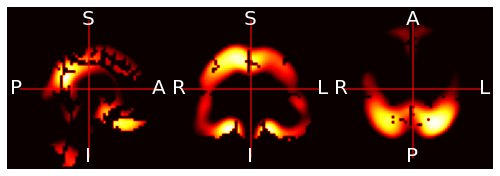

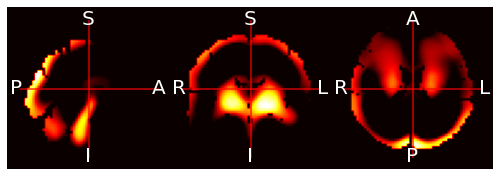

In [38]:
xcorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')
xcorr_r_nii_nii_neg.plot_ortho(flat=True,cmap='hot')

ycorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')
ycorr_r_nii_nii_neg.plot_ortho(flat=True,cmap='hot')

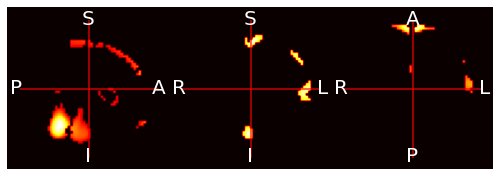

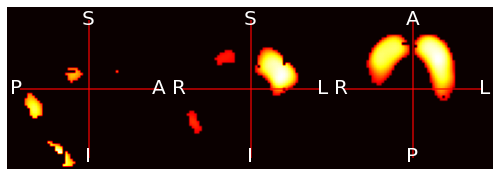

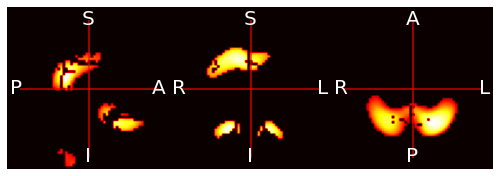

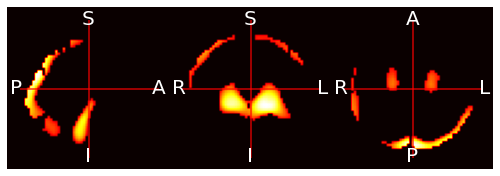

In [39]:
xcorr_r_threshed_nii_pos = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_nii_neg = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_nii_pos[xcorr_r_threshed_nii_pos<0] = 0
xcorr_r_threshed_nii_neg[xcorr_r_threshed_nii_neg>0] = 0

ycorr_r_threshed_nii_pos = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_nii_neg = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_nii_pos[ycorr_r_threshed_nii_pos<0] = 0
ycorr_r_threshed_nii_neg[ycorr_r_threshed_nii_neg>0] = 0


ycorr_r_threshed_nii_neg = ycorr_r_threshed_nii_neg.new_image_like(abs(ycorr_r_threshed_nii_neg.numpy()))
xcorr_r_threshed_nii_neg = xcorr_r_threshed_nii_neg.new_image_like(abs(xcorr_r_threshed_nii_neg.numpy()))


xcorr_r_threshed_nii_pos.plot_ortho(flat=True,cmap='hot')
xcorr_r_threshed_nii_neg.plot_ortho(flat=True,cmap='hot')

ycorr_r_threshed_nii_pos.plot_ortho(flat=True,cmap='hot')
ycorr_r_threshed_nii_neg.plot_ortho(flat=True,cmap='hot')

In [40]:
jacobians_flat.shape

(470, 262144)

In [41]:
xcorr_r_threshed_nii_pos.numpy().flatten().shape

(262144,)

### Volume increases and decreases along PCA axes

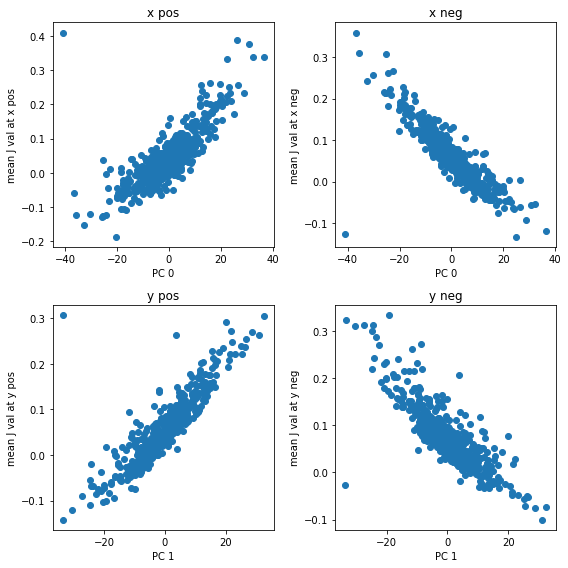

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
v1=j_pca[:,0]
v2=jacobians_flat[:,xcorr_r_threshed_nii_pos.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 0')
plt.ylabel('mean J val at x pos')
plt.title('x pos')

plt.subplot(2,2,2)
v1=j_pca[:,0]
v2=jacobians_flat[:,xcorr_r_threshed_nii_neg.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 0')
plt.ylabel('mean J val at x neg')
plt.title('x neg')

plt.subplot(2,2,3)
v1=j_pca[:,1]
v2=jacobians_flat[:,ycorr_r_threshed_nii_pos.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 1')
plt.ylabel('mean J val at y pos')
plt.title('y pos')

plt.subplot(2,2,4)
v1=j_pca[:,1]
v2=jacobians_flat[:,ycorr_r_threshed_nii_neg.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 1')
plt.ylabel('mean J val at y neg')
plt.title('y neg')

plt.tight_layout()

(array([  9.,  69., 184., 117.,  59.,  21.,   7.,   2.,   1.,   1.]),
 array([-0.0074505 ,  0.01352595,  0.03450239,  0.05547883,  0.07645528,
         0.09743172,  0.11840817,  0.13938461,  0.16036105,  0.1813375 ,
         0.20231394], dtype=float32),
 <BarContainer object of 10 artists>)

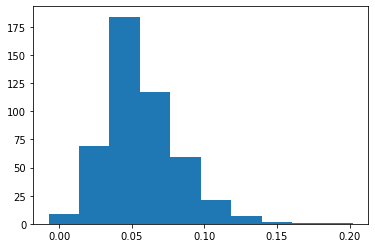

In [43]:
plt.hist(jacobians_flat[:,~np.isnan(xcorr_p)].mean(axis=1))